# Requirements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import numpy as np

# Load data and EDA

In [4]:
X_t0_path = "data/X_t0.parquet"  
y_t0_path = "data/y_t0.parquet"  

X_t0 = pd.read_parquet(X_t0_path).reset_index(drop=True)
y_t0 = pd.read_parquet(y_t0_path).reset_index(drop=True)

# Merge the datasets for joint analysis (optional)
df_y = X_t0.copy()

df = X_t0.copy()

In [5]:
# sample data
display(df.head())

,borrow_block_number,borrow_timestamp,wallet_address,first_tx_timestamp,last_tx_timestamp,wallet_age,incoming_tx_count,outgoing_tx_count,net_incoming_tx_count,total_gas_paid_eth,...,market_macdsignal,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,unique_borrow_protocol_count,unique_lending_protocol_count
0,7711117,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973049.0,199,438,-239,0.397391,...,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1
1,7711123,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973188.0,200,439,-239,0.399063,...,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1
2,7711126,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973238.0,201,440,-239,0.400895,...,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1
3,7711672,1.557205e+09,0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6,1.557191e+09,1.557198e+09,13922.0,8,56,-48,0.604001,...,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1
4,7712572,1.557217e+09,0xbd9ed130a53cfafcf81502e4d35329a6c4d53410,1.557217e+09,1.557217e+09,264.0,2,3,-1,0.003008,...,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1


In [6]:
# basic info
print("Shape of X_t0:", X_t0.shape)
print("Shape of y_t0:", y_t0.shape)
print("\nColumn Names in X_t0:")
print(X_t0.columns)

print("\nMissing Values in X_t0:")
print(X_t0.isnull().sum().value_counts())

Shape of X_t0: (44296, 77)
Shape of y_t0: (44296, 1)

Column Names in X_t0:
Index(['borrow_block_number', 'borrow_timestamp', 'wallet_address',
       'first_tx_timestamp', 'last_tx_timestamp', 'wallet_age',
       'incoming_tx_count', 'outgoing_tx_count', 'net_incoming_tx_count',
       'total_gas_paid_eth', 'avg_gas_paid_per_tx_eth', 'risky_tx_count',
       'risky_unique_contract_count', 'risky_first_tx_timestamp',
       'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff',
       'risky_sum_outgoing_amount_eth', 'outgoing_tx_sum_eth',
       'incoming_tx_sum_eth', 'outgoing_tx_avg_eth', 'incoming_tx_avg_eth',
       'max_eth_ever', 'min_eth_ever', 'total_balance_eth', 'risk_factor',
       'total_collateral_eth', 'total_collateral_avg_eth',
       'total_available_borrows_eth', 'total_available_borrows_avg_eth',
       'avg_weighted_risk_factor', 'risk_factor_above_threshold_daily_count',
       'avg_risk_factor', 'max_risk_factor', 'borrow_amount_sum_eth',
       'borr

In [7]:
# data types
data_types = df.dtypes.value_counts()
print("Summary of Data Types:")
print(data_types)

# Opcional: Listar columnas agrupadas por tipo
for dtype, group in df.dtypes.groupby(df.dtypes).groups.items():
    print(f"\nColumns with type '{dtype}':")
    print(list(group))


Summary of Data Types:
float64    60
int64      16
object      1
Name: count, dtype: int64

Columns with type 'int64':
['borrow_block_number', 'incoming_tx_count', 'outgoing_tx_count', 'net_incoming_tx_count', 'risky_tx_count', 'risky_unique_contract_count', 'risky_first_tx_timestamp', 'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff', 'borrow_count', 'repay_count', 'deposit_count', 'liquidation_count', 'market_ht_trendmode', 'unique_borrow_protocol_count', 'unique_lending_protocol_count']

Columns with type 'float64':
['borrow_timestamp', 'first_tx_timestamp', 'last_tx_timestamp', 'wallet_age', 'total_gas_paid_eth', 'avg_gas_paid_per_tx_eth', 'risky_sum_outgoing_amount_eth', 'outgoing_tx_sum_eth', 'incoming_tx_sum_eth', 'outgoing_tx_avg_eth', 'incoming_tx_avg_eth', 'max_eth_ever', 'min_eth_ever', 'total_balance_eth', 'risk_factor', 'total_collateral_eth', 'total_collateral_avg_eth', 'total_available_borrows_eth', 'total_available_borrows_avg_eth', 'avg_weighted_risk_fact


Missing Values in X_t0:
borrow_block_number              0
borrow_timestamp                 0
wallet_address                   0
first_tx_timestamp               0
last_tx_timestamp                0
                                ..
market_ppo                       0
market_rocp                      0
market_rocr                      0
unique_borrow_protocol_count     0
unique_lending_protocol_count    0
Length: 77, dtype: int64

Target Variable Distribution:
target
1         22656
0         21640
Name: count, dtype: int64


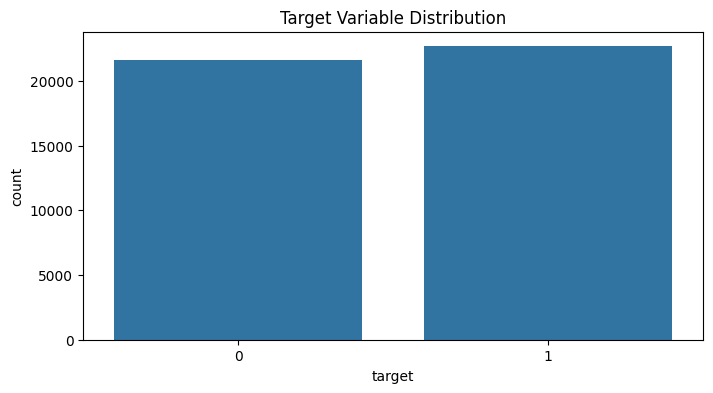

In [8]:
print("\nMissing Values in X_t0:")
print(X_t0.isnull().sum())

print("\nTarget Variable Distribution:")
print(y_t0.value_counts())

# 2. Visualizing the target variable distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=y_t0.iloc[:, 0])
plt.title("Target Variable Distribution")
plt.show()

In [9]:
# basic statistics
print(X_t0.describe(include='all'))

        borrow_block_number  borrow_timestamp  \
count          4.429600e+04      4.429600e+04   
unique                  NaN               NaN   
top                     NaN               NaN   
freq                    NaN               NaN   
mean           9.343121e+06      1.579559e+09   
std            7.772108e+05      1.070282e+07   
min            7.711117e+06      1.557197e+09   
25%            8.638256e+06      1.569687e+09   
50%            9.470717e+06      1.581544e+09   
75%            1.008743e+07      1.589770e+09   
max            1.033663e+07      1.593110e+09   

                                    wallet_address  first_tx_timestamp  \
count                                        44296        4.429600e+04   
unique                                        6788                 NaN   
top     0x586e32930ac05127de429bd566eaa2758fcbd9bc                 NaN   
freq                                          2467                 NaN   
mean                                     

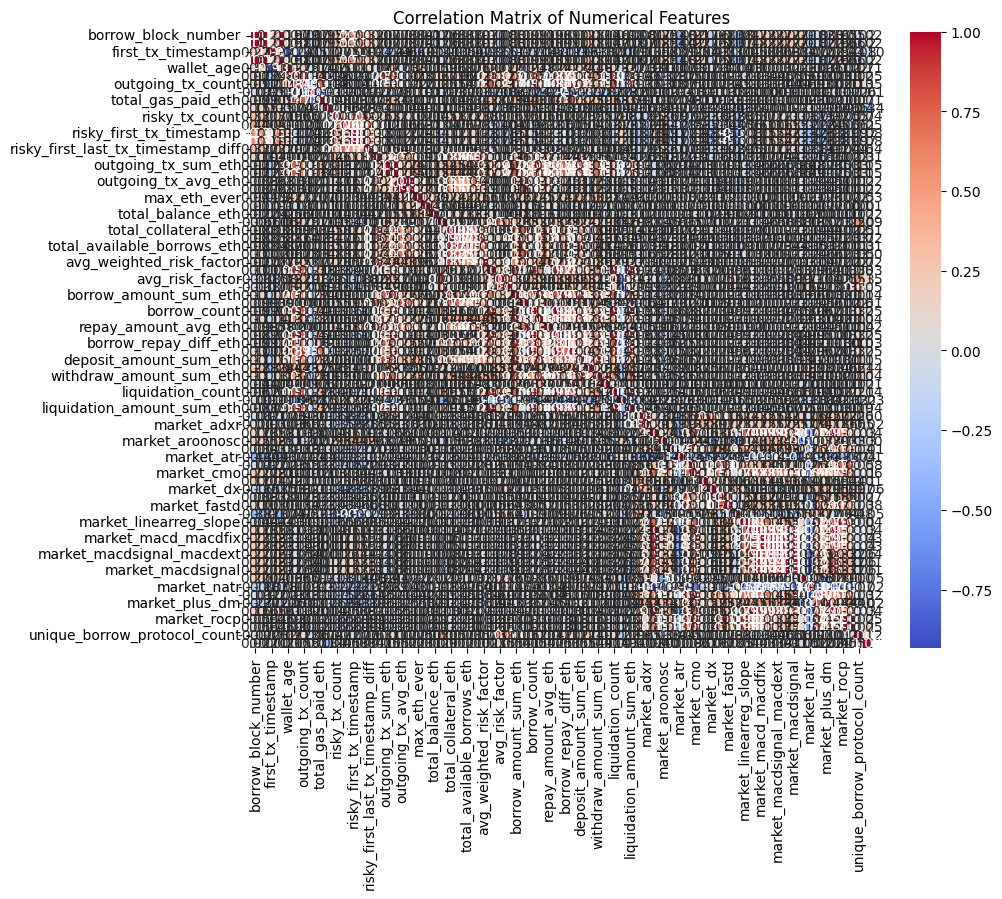


Categorical Variables Summary:

wallet_address:
wallet_address
0x586e32930ac05127de429bd566eaa2758fcbd9bc    2467
0x3e2dbda5f310aade1503557b2e7f356eaf161641     410
0x9709a9f77d4349e1da4220f1458fbe9339d612e3     401
0x40335581dd8692b698762168908d4ea23b0b94f9     296
0x18c42014fb0aed3e35515eb45df8498af67773a4     281
                                              ... 
0xf4c60d107d0201fe033e818e8e5d5c2b08c84374       1
0xc274d954a75036b7416d3c5e2e624e5c2086191b       1
0xfb05dd9c1722dee33fa3b3f86295069a454f2e04       1
0x12958035f5d05d4e8acda1264cca55937a4afae8       1
0x37d7b8aaf08df710245077e69922b508e46ebf4e       1
Name: count, Length: 6788, dtype: int64


In [10]:
# correlations num_features
numerical_cols = X_t0.select_dtypes(include=np.number).columns
if len(numerical_cols) > 0:
    corr_matrix = X_t0[numerical_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix of Numerical Features")
    plt.show()

# categorical vars
categorical_cols = X_t0.select_dtypes(include='object').columns
print("\nCategorical Variables Summary:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(X_t0[col].value_counts())

/var/folders/cw/t3sf_6b90js7ng58q25wlsm00000gn/T/ipykernel_15622/45697222.py:7: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout(pad=5.0, h_pad=2.0)  # Ajusta h_pad según sea necesario


<Figure size 3000x4000 with 0 Axes>

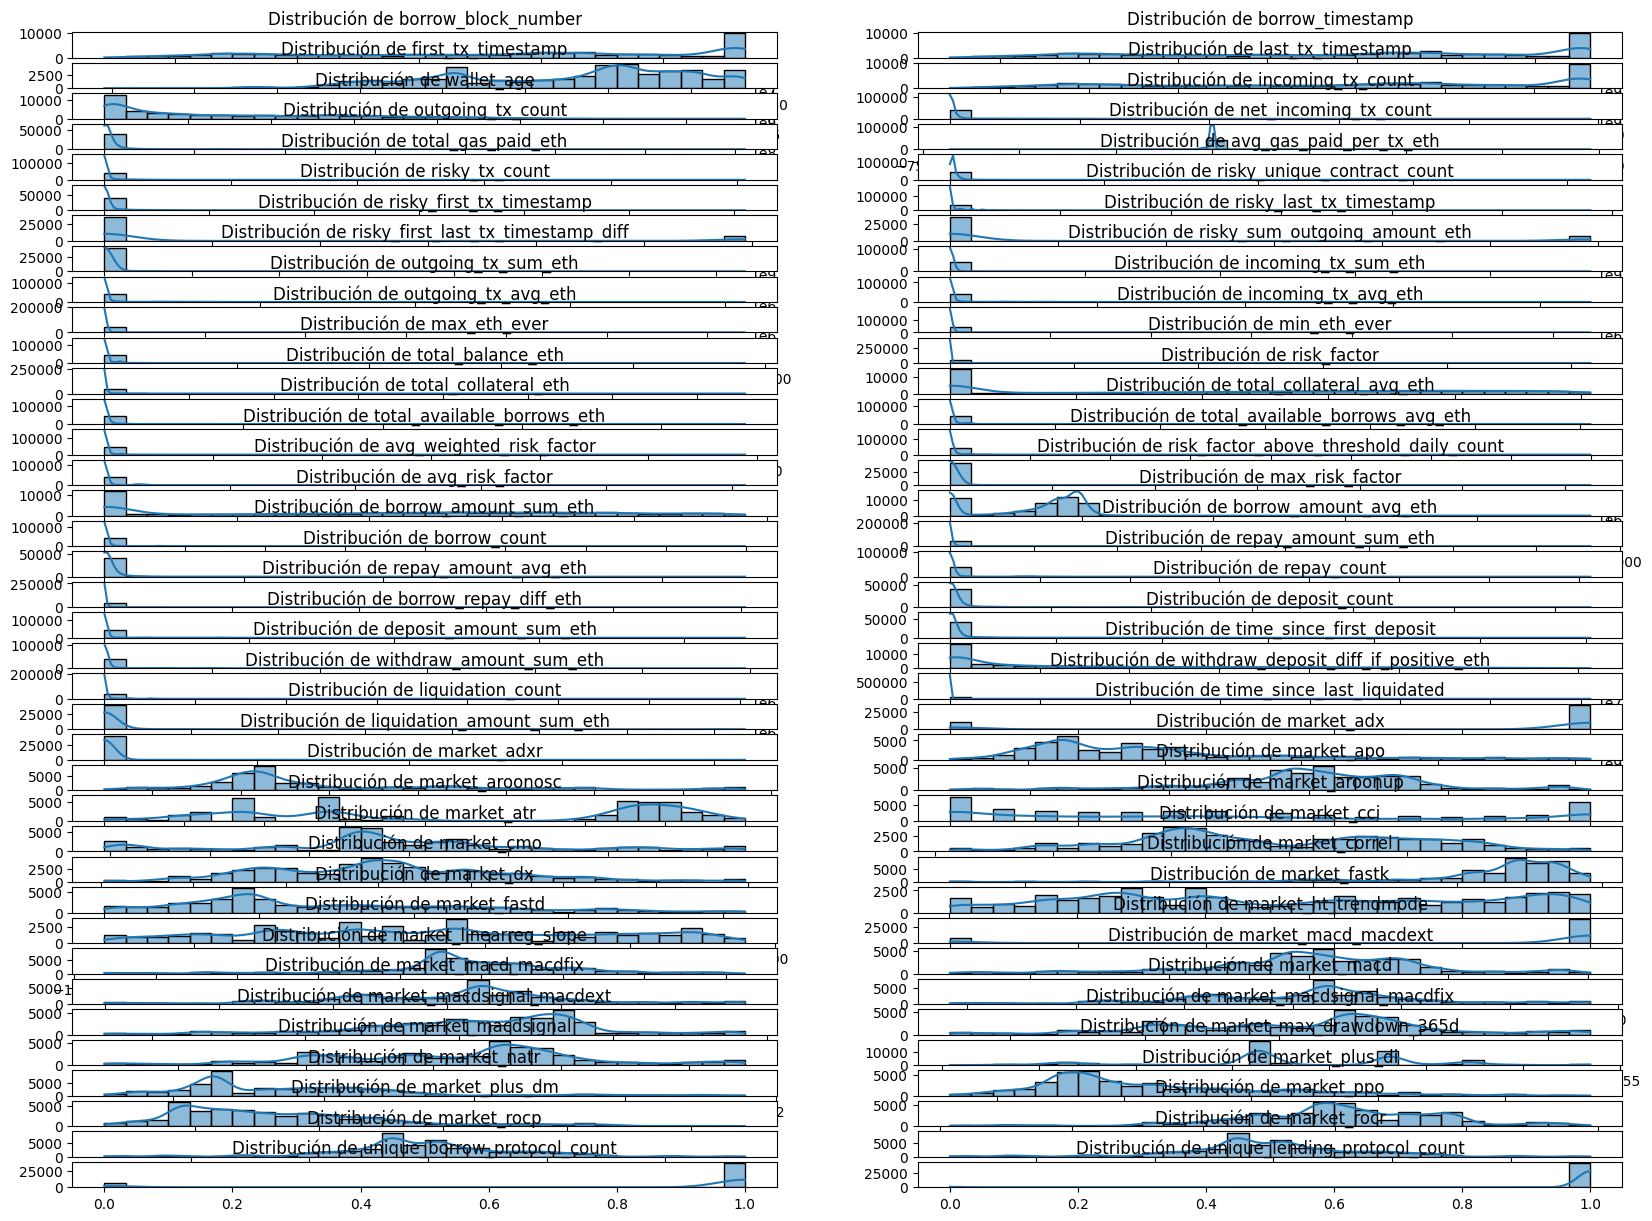

In [11]:
# Subconjunto de columnas numéricas
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Configurar la cuadrícula de subgráficos con más espacio vertical
plt.figure(figsize=(30, 40))
fig, axes = plt.subplots(nrows=len(numeric_columns) // 2, ncols=2, figsize=(20, 15), sharex=False)
fig.tight_layout(pad=5.0, h_pad=2.0)  # Ajusta h_pad según sea necesario

# Crear histogramas y gráficos de caja para cada columna numérica
for i, column in enumerate(numeric_columns):
    row, col = i // 2, i % 2
    sns.histplot(df[column], ax=axes[row, col], kde=True, bins=30)
    axes[row, col].set_title(f'Distribución de {column}')
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('')

plt.show()

/var/folders/cw/t3sf_6b90js7ng58q25wlsm00000gn/T/ipykernel_15622/581414112.py:7: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout(pad=5.0, h_pad=2.0)  # Ajusta h_pad según sea necesario


<Figure size 3000x4000 with 0 Axes>

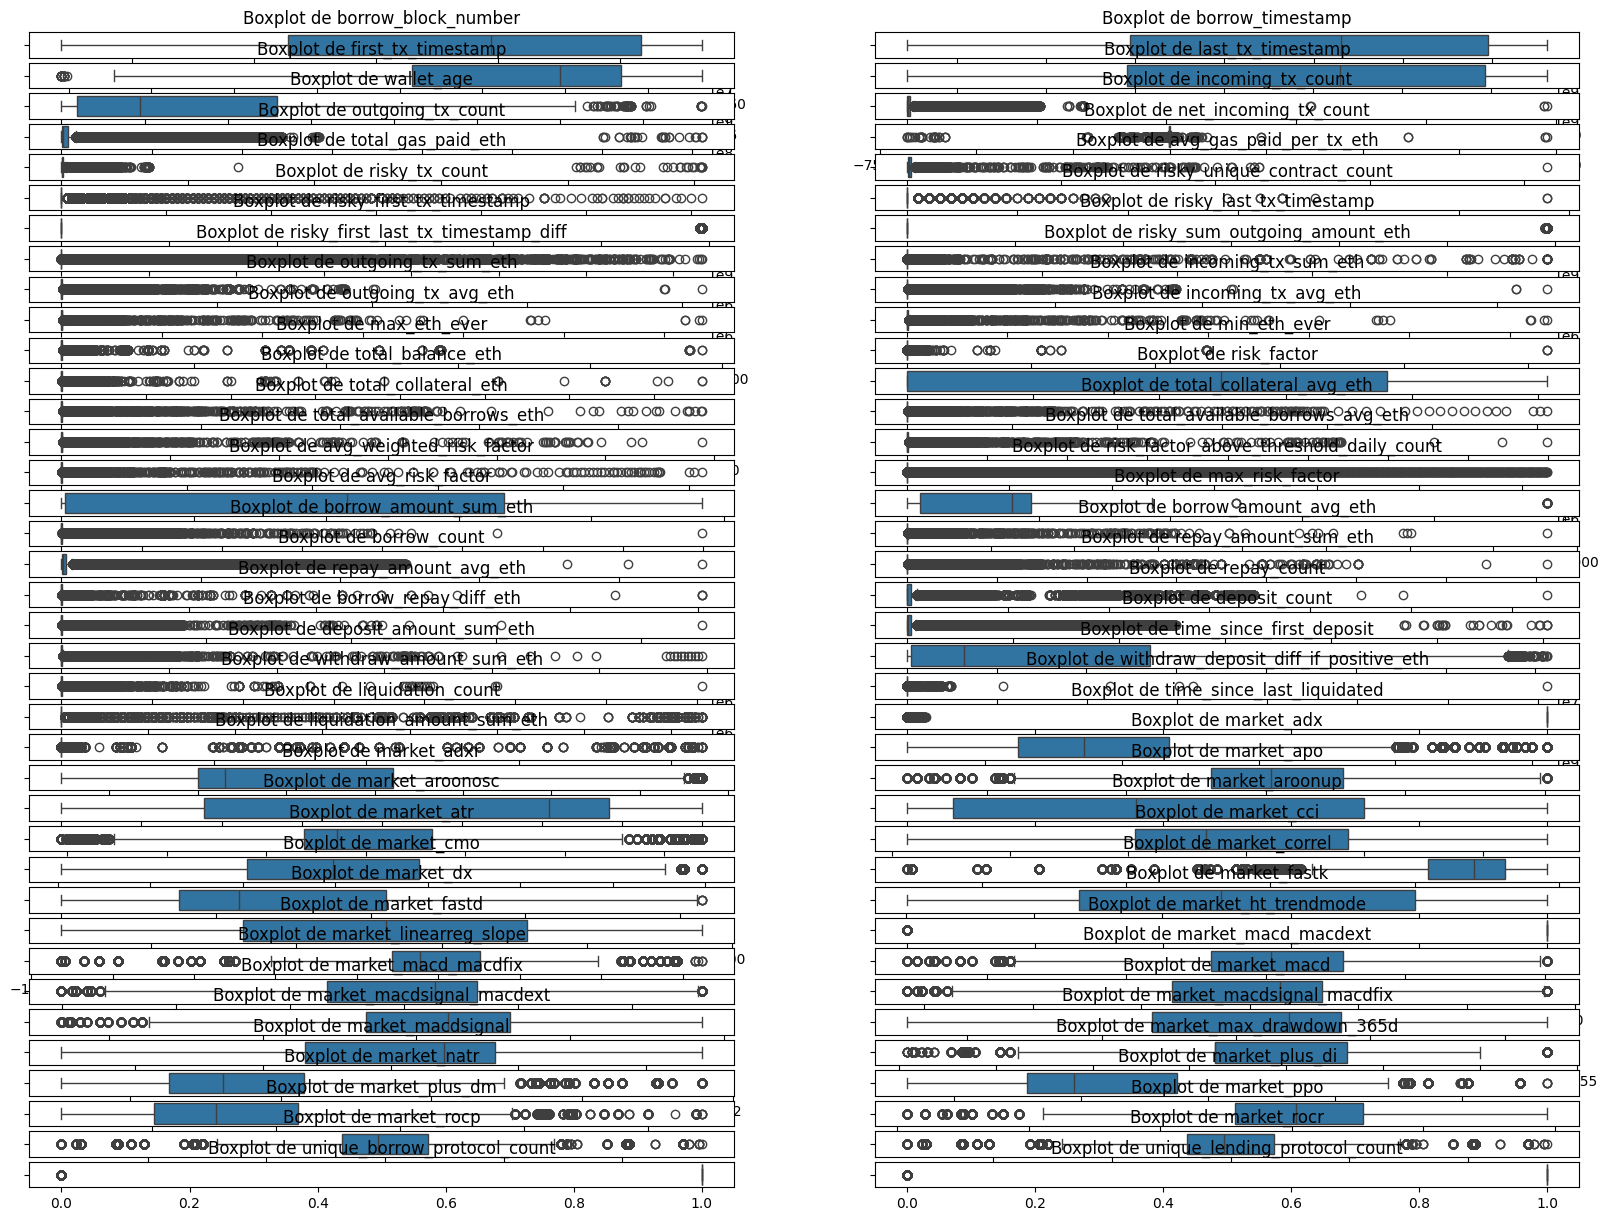

In [12]:
# Subconjunto de columnas numéricas
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Configurar la cuadrícula de subgráficos con más espacio vertical
plt.figure(figsize=(30, 40))
fig, axes = plt.subplots(nrows=len(numeric_columns) // 2, ncols=2, figsize=(20, 15), sharex=False)
fig.tight_layout(pad=5.0, h_pad=2.0)  # Ajusta h_pad según sea necesario

# Crear boxplots para cada columna numérica
for i, column in enumerate(numeric_columns):
    row, col = i // 2, i % 2
    sns.boxplot(x=df[column], ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot de {column}')
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('')

plt.show()


/var/folders/cw/t3sf_6b90js7ng58q25wlsm00000gn/T/ipykernel_15622/45697222.py:7: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout(pad=5.0, h_pad=2.0)  # Ajusta h_pad según sea necesario


<Figure size 3000x4000 with 0 Axes>

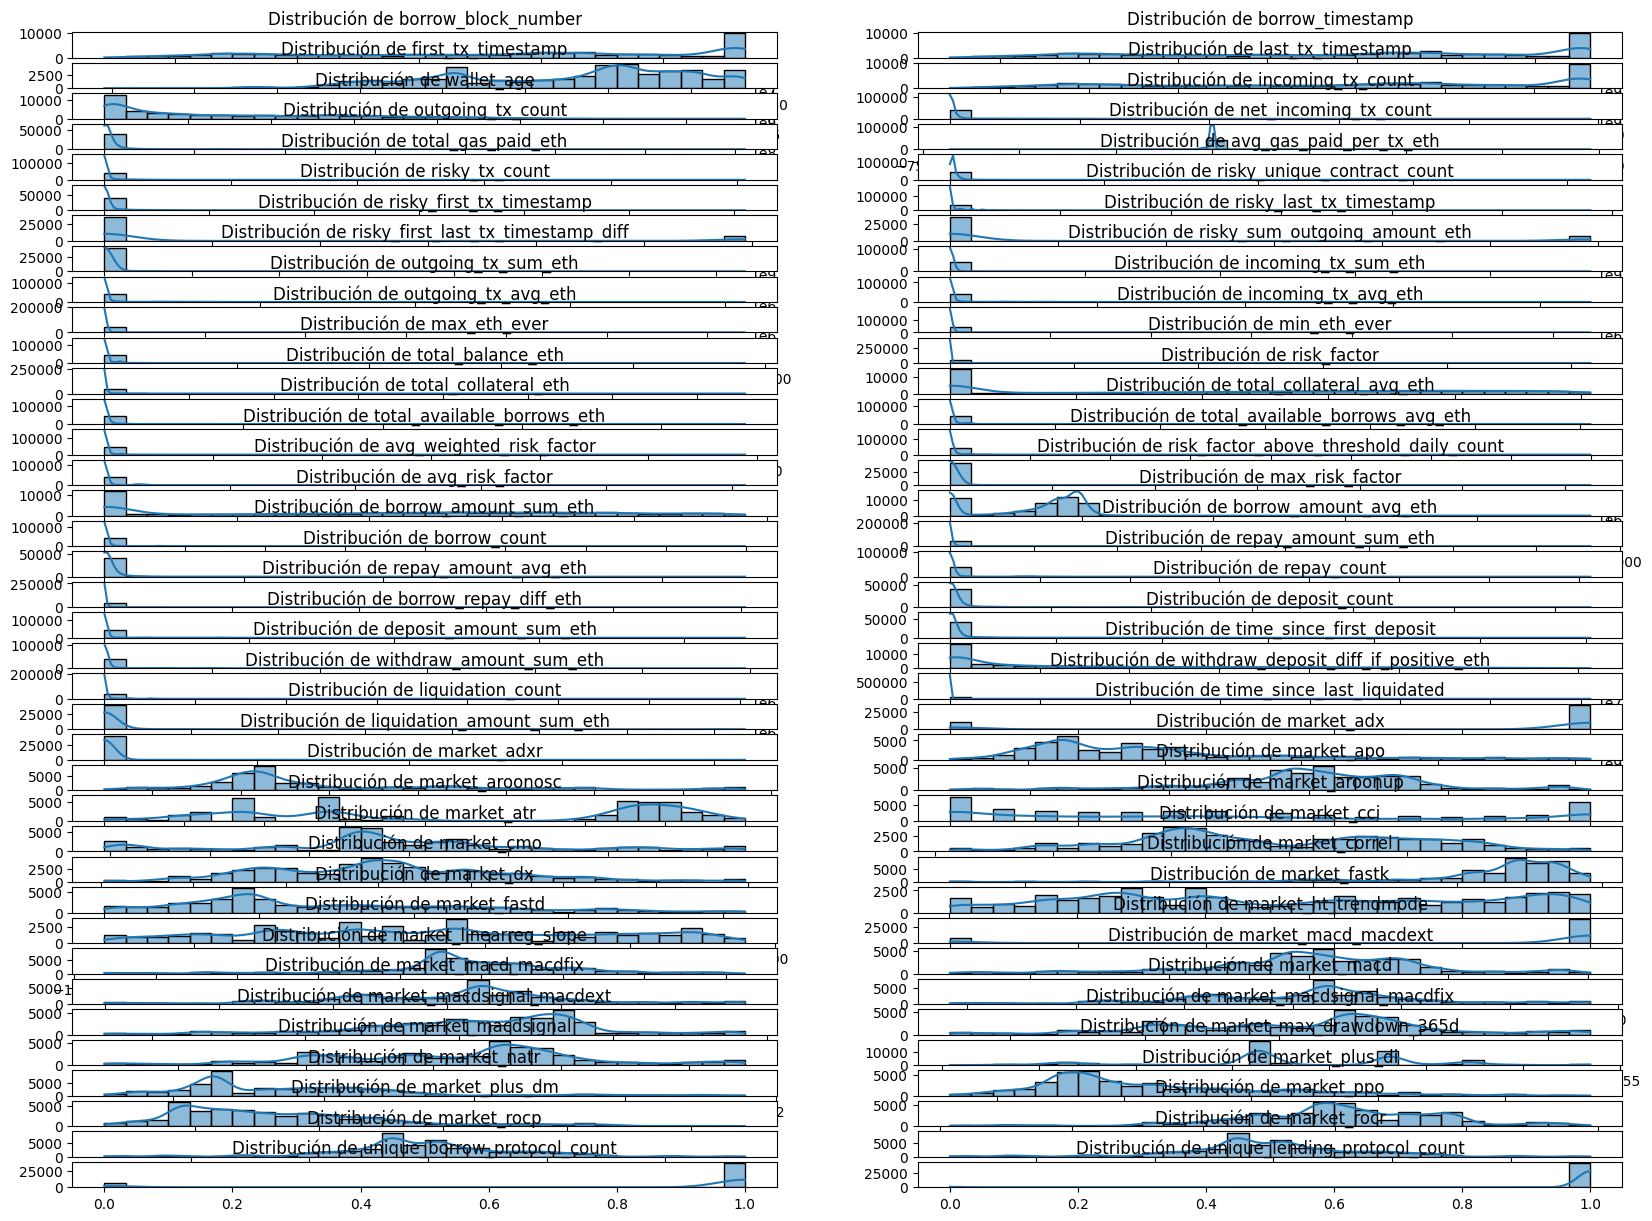

In [13]:
# Subconjunto de columnas numéricas
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Configurar la cuadrícula de subgráficos con más espacio vertical
plt.figure(figsize=(30, 40))
fig, axes = plt.subplots(nrows=len(numeric_columns) // 2, ncols=2, figsize=(20, 15), sharex=False)
fig.tight_layout(pad=5.0, h_pad=2.0)  # Ajusta h_pad según sea necesario

# Crear histogramas y gráficos de caja para cada columna numérica
for i, column in enumerate(numeric_columns):
    row, col = i // 2, i % 2
    sns.histplot(df[column], ax=axes[row, col], kde=True, bins=30)
    axes[row, col].set_title(f'Distribución de {column}')
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('')

plt.show()

Summary Statistics for wallet_age:
count    4.429600e+04
mean     2.943773e+07
std      2.897753e+07
min      1.370000e+02
25%      3.641601e+06
50%      1.900256e+07
75%      5.196818e+07
max      1.540836e+08
Name: wallet_age, dtype: float64


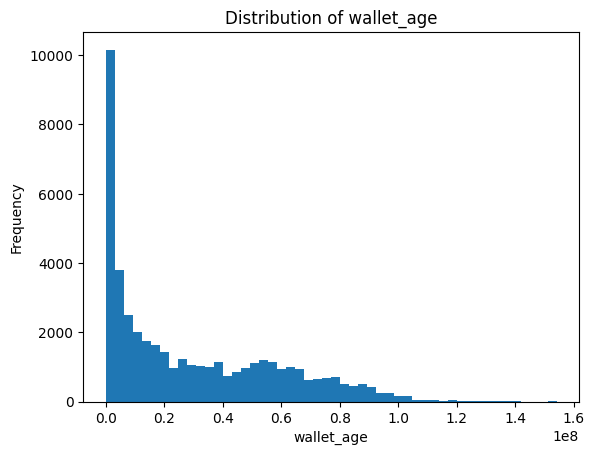

In [14]:
print("Summary Statistics for wallet_age:")
print(df['wallet_age'].describe())

# Histograma para observar la distribución
import matplotlib.pyplot as plt
plt.hist(df['wallet_age'], bins=50)
plt.title("Distribution of wallet_age")
plt.xlabel("wallet_age")
plt.ylabel("Frequency")
plt.show()


# Preprocessing

In [15]:
# Ver la cantidad total y porcentaje de valores nulos por columna
def missing_values_summary(df):
    total_missing = df.isnull().sum()
    percent_missing = (total_missing / len(df)) * 100
    missing_df = pd.DataFrame({'Total Missing': total_missing, 'Percent Missing': percent_missing})
    missing_df = missing_df[missing_df['Total Missing'] > 0]  # Filtramos solo columnas con valores nulos
    missing_df = missing_df.sort_values(by='Percent Missing', ascending=False)
    return missing_df

# Resumen de valores nulos
missing_summary = missing_values_summary(X_t0)
print("Missing Values Summary:")
print(missing_summary)

# Visualización de valores nulos
if not missing_summary.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_summary.index, y=missing_summary['Percent Missing'])
    plt.xticks(rotation=90)
    plt.title("Percentage of Missing Values by Column")
    plt.ylabel("Percent Missing")
    plt.xlabel("Columns")
    plt.show()
else:
    print("No missing values found!")


Missing Values Summary:
Empty DataFrame
Columns: [Total Missing, Percent Missing]
Index: []
No missing values found!


In [16]:
def high_correlations(df, threshold=0.8):
    """
    Encuentra y ordena pares de variables con correlación absoluta mayor a un umbral.
    
    Args:
        df (DataFrame): DataFrame de entrada con variables numéricas.
        threshold (float): Umbral de correlación.
    
    Returns:
        DataFrame: Pares de variables con alta correlación, ordenados de mayor a menor.
    """
    corr_matrix = df.corr().abs()  # Matriz de correlaciones absolutas
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # Parte superior de la matriz
    high_corr_pairs = upper_tri.stack().reset_index()  # Convertir a formato largo
    high_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
    high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > threshold]  # Filtrar por umbral
    high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)  # Ordenar de mayor a menor
    return high_corr_pairs

# Aplicar a las columnas numéricas del dataset
correlations = high_correlations(df[numerical_cols], threshold=0.8)

print("Pares de variables con alta correlación, ordenados de mayor a menor:")
print(correlations)



Pares de variables con alta correlación, ordenados de mayor a menor:
                     Variable 1               Variable 2  Correlation
2844                market_rocp              market_rocr     1.000000
2510                 market_apo      market_macd_macdext     1.000000
834    risky_first_tx_timestamp  risky_last_tx_timestamp     1.000000
2795  market_macdsignal_macdfix        market_macdsignal     0.999990
2759        market_macd_macdfix              market_macd     0.999987
...                         ...                      ...          ...
1103        outgoing_tx_sum_eth   deposit_amount_sum_eth     0.812167
504       net_incoming_tx_count       total_gas_paid_eth     0.812142
2601                 market_cci             market_fastd     0.810269
2627                 market_cmo              market_macd     0.808223
2626                 market_cmo      market_macd_macdfix     0.806546

[98 rows x 3 columns]


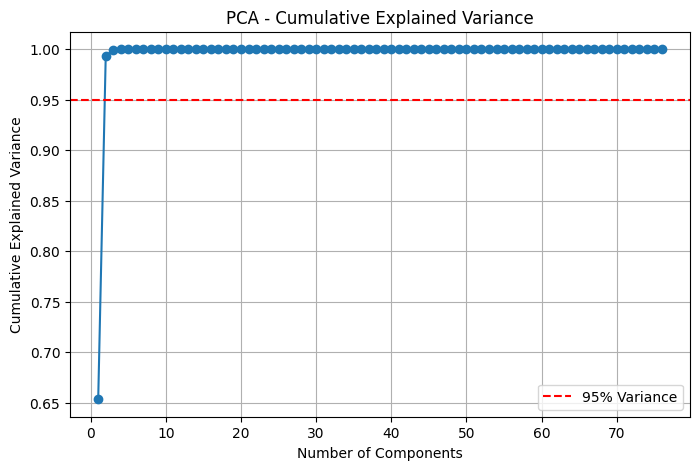

Suggested number of components for 95% variance: 2


In [17]:
def analyze_pca(df, n_components=None):
    """
    Evalúa la varianza explicada acumulada por PCA y sugiere un número óptimo de componentes.
    Args:
        df (DataFrame): DataFrame de entrada (solo variables numéricas).
        n_components (int): Número de componentes a evaluar, si no se especifica se usa el total.
    Returns:
        None: Genera gráficos y sugiere un número óptimo de componentes.
    """
    pca = PCA(n_components=n_components)
    pca.fit(df)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Gráfico de varianza explicada acumulada
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
    plt.axhline(y=0.95, color='r', linestyle='--', label="95% Variance")
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA - Cumulative Explained Variance')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Sugerir número de componentes
    optimal_components = np.argmax(explained_variance >= 0.95) + 1
    print(f"Suggested number of components for 95% variance: {optimal_components}")

# Aplicar a las columnas numéricas
analyze_pca(df[numerical_cols])


In [18]:
# Feature engineering
def feature_engineering(df):
    """
    Aplica transformaciones para crear nuevas características en el dataset.
    Args:
        df (DataFrame): DataFrame original preprocesado.
    Returns:
        DataFrame: DataFrame con nuevas características añadidas.
    """
    df = df.copy()  # Evitar modificar el original
    
    # 1. Crear ratios
    if 'total_balance_eth' in df.columns and 'unique_borrow_protocol_count' in df.columns:
        df['balance_per_protocol'] = df['total_balance_eth'] / (df['unique_borrow_protocol_count'] + 1)
    
    if 'risk_factor' in df.columns and 'borrow_amount_avg_eth' in df.columns:
        df['weighted_risk'] = df['risk_factor'] * df['borrow_amount_avg_eth']
    
    # 2. Transformaciones logarítmicas
    if 'total_balance_eth' in df.columns:
        df['log_total_balance'] = np.log1p(df['total_balance_eth'])  # log(1 + x) para evitar log(0)
    
    # 3. Rankings
    if 'avg_gas_paid_per_tx_eth' in df.columns:
        df['gas_rank'] = df['avg_gas_paid_per_tx_eth'].rank(ascending=False)
    
    # Transformación logarítmica
    if 'wallet_age' in df.columns:
        df['log_wallet_age'] = np.log1p(df['wallet_age'])  # log(1 + x) para evitar log(0)
        df['log_wallet_age'] = df['log_wallet_age'].fillna(0) 

    # Conversión a años (si wallet_age es tiempo en segundos)
    if 'wallet_age' in df.columns:
        df['wallet_age_years'] = df['wallet_age'] / (60 * 60 * 24 * 365)  # Aproximar a años

    # 5. Interacciones adicionales (ejemplo con timestamps)
    if 'borrow_timestamp_year' in df.columns and 'first_tx_timestamp_year' in df.columns:
        df['time_since_borrow'] = df['borrow_timestamp_year'] - df['first_tx_timestamp_year']
    
    return df


In [19]:
# Aplicar feature engineering
df_features = feature_engineering(df)

# Revisar las primeras filas del dataset con nuevas características
print("Processed Data with New Features:")
display(df_features.head())


Processed Data with New Features:


,borrow_block_number,borrow_timestamp,wallet_address,first_tx_timestamp,last_tx_timestamp,wallet_age,incoming_tx_count,outgoing_tx_count,net_incoming_tx_count,total_gas_paid_eth,...,market_rocp,market_rocr,unique_borrow_protocol_count,unique_lending_protocol_count,balance_per_protocol,weighted_risk,log_total_balance,gas_rank,log_wallet_age,wallet_age_years
0,7711117,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973049.0,199,438,-239,0.397391,...,0.104294,1.104294,0,1,58.317987,0.000000,4.082913,32436.0,16.809894,0.633341
1,7711123,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973188.0,200,439,-239,0.399063,...,0.104294,1.104294,1,1,29.158993,0.000778,4.082913,32404.0,16.809901,0.633346
2,7711126,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973238.0,201,440,-239,0.400895,...,0.104294,1.104294,1,1,29.158993,0.004646,4.082913,32354.0,16.809904,0.633347
3,7711672,1.557205e+09,0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6,1.557191e+09,1.557198e+09,13922.0,8,56,-48,0.604001,...,0.104294,1.104294,0,1,0.000000,0.000000,0.000000,1079.0,9.541297,0.000441
4,7712572,1.557217e+09,0xbd9ed130a53cfafcf81502e4d35329a6c4d53410,1.557217e+09,1.557217e+09,264.0,2,3,-1,0.003008,...,0.104294,1.104294,0,1,0.000000,0.000000,0.000000,32029.0,5.579730,0.000008


In [20]:
categorical_columns = []  
timestamp_columns = ['borrow_timestamp', 'first_tx_timestamp', 'last_tx_timestamp']  # Variables de tiempo
numerical_columns = [col for col in df_features.columns if col not in timestamp_columns + ['wallet_address']]  
df_features = df_features.drop(columns=['wallet_address'])

# 2. Transformador personalizado para fechas
class DateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        transformed = pd.DataFrame()  # Crear un DataFrame temporal
        for col in X.columns:
            transformed[f'{col}_year'] = pd.to_datetime(X[col], unit='s').dt.year
            transformed[f'{col}_month'] = pd.to_datetime(X[col], unit='s').dt.month
            transformed[f'{col}_day'] = pd.to_datetime(X[col], unit='s').dt.day
        return transformed.values  # Convertir a array numérico compatible

# 3. Configurar ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
            # pca
        ]), numerical_columns),  # Escalado de numéricas
        #('cat', OrdinalEncoder(),  categorical_columns),
        ('date', DateTransformer(), timestamp_columns)  # Transformación de fechas
    ],
    remainder='passthrough'  # Passthrough para dejar columnas no especificadas
)

# 4. Crear nombres de columnas para los datos transformados
# Nombres de las columnas numéricas
numerical_names = numerical_columns

# Nombres de las columnas transformadas por DateTransformer
date_names = [f"{col}_{suffix}" for col in timestamp_columns for suffix in ['year', 'month', 'day']]

# Combinar todos los nombres de columnas
transformed_column_names = numerical_names+ date_names 

# 5. Crear el pipeline completo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)  # Solo preprocesamiento en este ejemplo
])

# 6. Aplicar el preprocesamiento al dataset
processed_data = pipeline.fit_transform(df_features)

# 7. Convertir a DataFrame con los nombres generados
processed_data_df = pd.DataFrame(processed_data, columns=transformed_column_names)

# 8. Revisar el resultado
print("Processed Data Shape:", processed_data_df.shape)
print("Processed Data Head:")
display(processed_data_df.head())


Processed Data Shape: (44296, 88)
Processed Data Head:


,borrow_block_number,wallet_age,incoming_tx_count,outgoing_tx_count,net_incoming_tx_count,total_gas_paid_eth,avg_gas_paid_per_tx_eth,risky_tx_count,risky_unique_contract_count,risky_first_tx_timestamp,...,wallet_age_years,borrow_timestamp_year,borrow_timestamp_month,borrow_timestamp_day,first_tx_timestamp_year,first_tx_timestamp_month,first_tx_timestamp_day,last_tx_timestamp_year,last_tx_timestamp_month,last_tx_timestamp_day
0,-2.099846,-0.326625,-0.261122,-0.234284,0.056233,-0.173391,-0.232649,-0.254934,-0.323385,-0.469442,...,-0.326625,2019.0,5.0,7.0,2018.0,9.0,17.0,2019.0,5.0,7.0
1,-2.099838,-0.326620,-0.260796,-0.234030,0.056233,-0.173266,-0.232440,-0.254934,-0.323385,-0.469442,...,-0.326620,2019.0,5.0,7.0,2018.0,9.0,17.0,2019.0,5.0,7.0
2,-2.099834,-0.326619,-0.260469,-0.233776,0.056233,-0.173129,-0.232184,-0.254934,-0.323385,-0.469442,...,-0.326619,2019.0,5.0,7.0,2018.0,9.0,17.0,2019.0,5.0,7.0
3,-2.099132,-1.015413,-0.323436,-0.331325,0.144352,-0.157949,0.972234,-0.254934,-0.323385,-0.469442,...,-1.015413,2019.0,5.0,7.0,2019.0,5.0,7.0,2019.0,5.0,7.0
4,-2.097974,-1.015884,-0.325393,-0.344789,0.166036,-0.202867,-0.230024,-0.254934,-0.323385,-0.469442,...,-1.015884,2019.0,5.0,7.0,2019.0,5.0,7.0,2019.0,5.0,7.0


# Hold out

In [21]:
from sklearn.model_selection import train_test_split

X = df_features
y = y_t0['target']

# Dividir el conjunto de datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Dividir el conjunto de entrenamiento en entrenamiento (70%) y validación (30%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# Imprimir las formas de los conjuntos resultantes
print("Conjunto de Entrenamiento:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("\nConjunto de Validación:")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

print("\nConjunto de Prueba:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Conjunto de Entrenamiento:
X_train shape: (24805, 82)
y_train shape: (24805,)

Conjunto de Validación:
X_val shape: (10631, 82)
y_val shape: (10631,)

Conjunto de Prueba:
X_test shape: (8860, 82)
y_test shape: (8860,)


# Baseline

In [22]:
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Lista para almacenar las métricas
metrics_results = []

# Función para entrenar y evaluar un pipeline con un modelo específico
def train_evaluate_pipeline(model, pipeline_name):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Entrenar el pipeline
    pipeline.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = pipeline.predict(X_test)

    # Imprimir classification_report
    print(f"Classification Report - {pipeline_name}:")
    print(classification_report(y_test, y_pred))

    # Calcular y guardar la métrica
    f1 = f1_score(y_test, y_pred, average='weighted')
    metrics_results.append({'Model': pipeline_name, 'F1-score': f1})

# Semilla global para reproducibilidad
seed = 42

# Modelos a evaluar
models_to_evaluate = {
    'Dummy': DummyClassifier(strategy='stratified'),
    'Logistic Regression': LogisticRegression(random_state=seed),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=seed),
    'SVM': SVC(random_state=seed),
    'Random Forest': RandomForestClassifier(random_state=seed),
    'LightGBM': LGBMClassifier(random_state=seed),
    'XGBoost': XGBClassifier(random_state=seed)
}

# Iterar sobre los modelos y evaluar los pipelines
for model_name, model in models_to_evaluate.items():
    train_evaluate_pipeline(model, model_name)

Classification Report - Dummy:
              precision    recall  f1-score   support

           0       0.49      0.50      0.49      4328
           1       0.51      0.50      0.51      4532

    accuracy                           0.50      8860
   macro avg       0.50      0.50      0.50      8860
weighted avg       0.50      0.50      0.50      8860



/Users/alejandratoro/miniconda3/envs/torchenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      4328
           1       0.75      0.75      0.75      4532

    accuracy                           0.75      8860
   macro avg       0.75      0.75      0.75      8860
weighted avg       0.75      0.75      0.75      8860

Classification Report - KNN:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      4328
           1       0.79      0.80      0.79      4532

    accuracy                           0.79      8860
   macro avg       0.79      0.79      0.79      8860
weighted avg       0.79      0.79      0.79      8860

Classification Report - Decision Tree:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      4328
           1       0.82      0.84      0.83      4532

    accuracy                           0.82      8860
   macro avg   

/Users/alejandratoro/miniconda3/envs/torchenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alejandratoro/miniconda3/envs/torchenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alejandratoro/miniconda3/envs/torchenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      4328
           1       0.93      0.85      0.89      4532

    accuracy                           0.89      8860
   macro avg       0.89      0.89      0.89      8860
weighted avg       0.89      0.89      0.89      8860

[LightGBM] [Info] Number of positive: 12687, number of negative: 12118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17937
[LightGBM] [Info] Number of data points in the train set: 24805, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511469 -> initscore=0.045886
[LightGBM] [Info] Start training from score 0.045886
Classification Report - LightGBM:
              precision    recall  f1-score   support

           0       0.82      0.92      0.86      432

In [23]:
# Convertir el diccionario en un DataFrame
metrics_df = pd.DataFrame(metrics_results)

# Ordenar el DataFrame por F1-score de mayor a menor
metrics_df = metrics_df.sort_values(by='F1-score', ascending=False)

# Mostrar resultados finales
print("\nResults:")
display(metrics_df)


Results:


,Model,F1-score
5,Random Forest,0.890543
7,XGBoost,0.881319
6,LightGBM,0.859160
3,Decision Tree,0.820343
2,KNN,0.787902
1,Logistic Regression,0.747070
0,Dummy,0.500623
4,SVM,0.346203


# Opt Models

In [24]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier


In [25]:
# Función de objetivo para Random Forest
def objective_rf(trial):
    # Elegir entre un tipo de valor para max_features: entero, flotante, 'sqrt' o 'log2'
    max_features_type = trial.suggest_categorical('max_features_type', ['int', 'float', 'sqrt', 'log2'])

    if max_features_type == 'int':
        # Si es entero, sugerir un valor entero
        max_features = trial.suggest_int('max_features_int', 1, X_train.shape[1])
    elif max_features_type == 'float':
        # Si es flotante, sugerir un valor flotante
        max_features = trial.suggest_float('max_features_float', 0.1, 1.0)
    else:
        # Si es 'sqrt' o 'log2', usar el valor tal cual
        max_features = max_features_type

    # Hiperparámetros de Random Forest
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),  # Número de árboles
        'max_depth': trial.suggest_int('max_depth', 3, 20),  # Profundidad máxima
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),  # Mínimos splits
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),  # Muestras mínimas por hoja
        'max_features': max_features  # Características máximas (determinado dinámicamente)
    }

    # Crear el modelo con los hiperparámetros sugeridos
    model = RandomForestClassifier(**param, random_state=seed)

    # Pipeline con preprocesamiento y modelo
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Evaluación con validación cruzada
    score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=3, scoring='f1_weighted').mean()
    return score


In [ ]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=100)

# Mejores hiperparámetros para Random Forest
print("Mejores hiperparámetros para Random Forest:", study_rf.best_params)

[I 2024-11-28 15:57:24,821] A new study created in memory with name: no-name-5bbaf8aa-5c80-4684-97dc-bf866e08b845
[I 2024-11-28 15:57:30,938] Trial 0 finished with value: 0.8578955975005386 and parameters: {'max_features_type': 'log2', 'n_estimators': 119, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8578955975005386.
[I 2024-11-28 15:57:39,053] Trial 1 finished with value: 0.7749929193767165 and parameters: {'max_features_type': 'int', 'max_features_int': 45, 'n_estimators': 87, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8578955975005386.
[I 2024-11-28 15:57:51,913] Trial 2 finished with value: 0.824794847882054 and parameters: {'max_features_type': 'sqrt', 'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8578955975005386.
[I 2024-11-28 15:57:55,683] Trial 3 finished with value: 0.8411870944027187 and parameters: {'m

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

best_params_rf = study_rf.best_params  # Extraer los mejores parámetros

# Extraer el valor correcto para max_features
if best_params_rf['max_features_type'] == 'int':
    max_features_rf = best_params_rf['max_features_int']
elif best_params_rf['max_features_type'] == 'float':
    max_features_rf = best_params_rf['max_features_float']
else:
    max_features_rf = best_params_rf['max_features_type']

# Crear el modelo RandomForestClassifier con los mejores parámetros
model_rf = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=max_features_rf,
    random_state=seed
)

# Pipeline para Random Forest
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model_rf)
])

# Entrenar Random Forest
pipeline_rf.fit(X_train, y_train)

# Evaluar en conjunto de validación
y_pred_rf_val = pipeline_rf.predict(X_val)
y_pred_rf_test = pipeline_rf.predict(X_test)

# Evaluar métricas para Random Forest
print("\n=== Random Forest Metrics ===")
print("Validation Metrics:")
print(classification_report(y_val, y_pred_rf_val))
print("Test Metrics:")
print(classification_report(y_test, y_pred_rf_test))

# 3. Evaluar ROC-AUC para ambos modelos (opcional)
y_proba_rf = pipeline_rf.predict_proba(X_test)[:, 1]

roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"Random Forest Test ROC-AUC: {roc_auc_rf:.4f}")


# Eval and Interpretability

In [ ]:
# Evaluar en el conjunto de validación
print("Random Forest - Validation Performance")
print(classification_report(y_val, y_pred_rf))

# Evaluar el modelo seleccionado en el conjunto de prueba
print("Random Forest - Test Performance")
print(classification_report(y_test, y_pred_test_rf))

In [ ]:
from optuna.visualization import plot_param_importances
plot_param_importances(study_rf)

In [ ]:
#Imabalanced learn 
best_rf_params = study_rf.best_params.copy()

# Procesar el parámetro 'max_features'
max_features_type = best_rf_params.pop('max_features_type')
if max_features_type == 'int':
    max_features = best_rf_params.pop('max_features_int')
elif max_features_type == 'float':
    max_features = best_rf_params.pop('max_features_float')
else:
    max_features = max_features_type

# Agregar el parámetro 'max_features' procesado
best_rf_params['max_features'] = max_features

# Crear el pipeline con SMOTE para Random Forest
pipeline_smote_rf = make_pipeline_imblearn(
    preprocessor,
    smote,
    RandomForestClassifier(**best_rf_params, random_state=seed)
)

# Entrenar el pipeline con SMOTE para Random Forest
pipeline_smote_rf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_rf = pipeline_smote_rf.predict(X_test)

# Imprimir el informe de clasificación para Random Forest
print(classification_report(y_test, y_pred_rf))


In [ ]:
best_model_rf = pipeline_rf.named_steps['classifier']

In [ ]:
# Obtener la importancia de las características
feature_importances = best_model_rf.feature_importances_

# Obtener los transformadores dentro del ColumnTransformer
transformers = [trans[1] for trans in preprocessor.transformers_ if trans[0] != 'remainder']

# Inicializar una lista para almacenar los nombres de las características
feature_names = []

# Iterar sobre los transformadores para obtener los nombres de las características
for transformer in transformers:
    if hasattr(transformer, 'get_feature_names_out'):
        # Para transformadores que soportan get_feature_names_out
        feature_names.extend(transformer.get_feature_names_out())
    else:
        # Asumir que el transformador no cambia los nombres (como SimpleImputer)
        feature_names.extend(transformer.get_feature_names())

# Asegurarse de que la longitud de feature_names coincida con el número de características
assert len(feature_names) == len(feature_importances)

# Crear el DataFrame
features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Importancia de las Características en el Modelo LightGBM')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()

In [ ]:
import shap

# Asumiendo que preprocessing_transformer es un ColumnTransformer
feature_names = preprocessor.get_feature_names_out()

# Crear un explainer SHAP utilizando el modelo LightGBM
explainer = shap.Explainer(pipeline_rf.named_steps['classifier'])
shap_values = explainer.shap_values(pipeline_rf.named_steps['preprocessor'].transform(X_train))

# Visualización global: Importancia de las características
shap.summary_plot(shap_values, feature_names=feature_names, plot_type="bar")

In [ ]:
# Crear un explainer SHAP utilizando el modelo LightGBM
explainer = shap.Explainer(pipeline_rf.named_steps['classifier'])

# Transformar las características con el preprocesador y calcular los valores SHAP
X_transformed = pipeline_rf.named_steps['preprocessor'].transform(X_train)
shap_values = explainer.shap_values(X_transformed)

#np.random.seed(42) 

# Seleccionar 10 observaciones aleatorias
#random_indices = np.random.choice(X_transformed.shape[0], 10, replace=False)
random_indices = np.array([3793,  543,  821, 4329, 2056, 2438, 1631, 2803,  232, 5199])

# Visualizar las contribuciones de las características para cada observación seleccionada
# Asumiendo un clasificador binario, usamos shap_values[1] para la clase positiva
for i in random_indices:
    shap.decision_plot(explainer.expected_value[1], shap_values[1][i], feature_names=feature_names)
    plt.show()

# Preds on test

In [ ]:
X_t1 = "data/X_t1.parquet"  

X_t1 = pd.read_parquet(X_t1_path).reset_index(drop=True)

In [ ]:
pipe_clf = pipeline_rf

In [ ]:
from zipfile import ZipFile
import os
def generateFiles(predict_data, clf_pipe):
    """Genera los archivos a subir en CodaLab

    Input
    ---------------
    predict_data: Dataframe con los datos de entrada a predecir
    clf_pipe: pipeline del clf

    Ouput
    ---------------
    archivo de txt
    """
    y_pred_clf = clf_pipe.predict_proba(predict_data)[:, 1]
    with open('./predictions.txt', 'w') as f:
        for item in y_pred_clf:
            f.write("%s\n" % item)
    
    with ZipFile('predictions.zip', 'w') as zipObj:
        zipObj.write('predictions.txt')
    os.remove('predictions.txt')

generateFiles(X_t1, pipe_clf)